# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # prevent tensorflow from using GPU

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.compat.v1.enable_eager_execution()

import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from operator import mul
from sklearn.cluster import KMeans

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
TensorFlow version: 1.15.0-dev20190821
TensorFlow Probability version: 0.9.0-dev20190920


## Generate some data

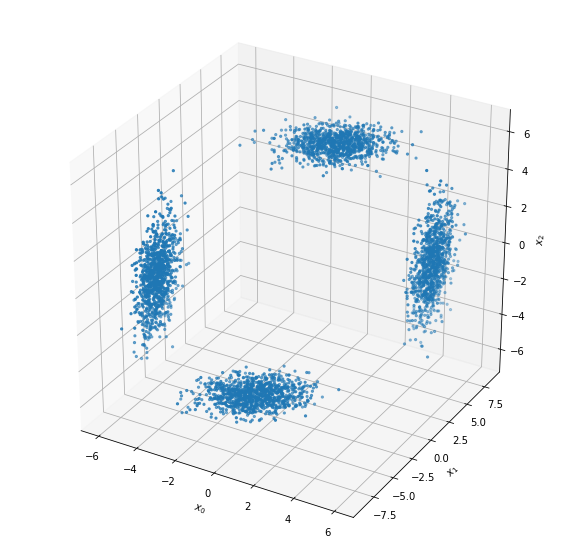

In [2]:
eps = 1e-3

n_samples_per_component = 1000
n_dims = 3
X = []
X.append(np.random.multivariate_normal([5, 5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float32'))
X.append(np.random.multivariate_normal([-5, -5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float32'))
X.append(np.random.multivariate_normal([0, 5, 5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float32'))
X.append(np.random.multivariate_normal([0, -5, -5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float32'))
n_components = len(X)
n_samples = n_samples_per_component * n_components
X = np.concatenate(X)

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.show()

## Make a TensorFlow Dataset from that data

In [3]:
batch_size = 2000
dataset = tf.data.Dataset.from_tensor_slices((X)).shuffle(10000).batch(batch_size)

## KL divergence between two Wishart distributions

In [4]:
@tf.function
def kl_Wishart(dist_a, dist_b):
    assert isinstance(dist_a, tfd.Wishart), "distribution A must be a Wishart distribution"
    assert isinstance(dist_b, tfd.Wishart), "distribution B must be a Wishart distribution"
    df_a = dist_a.df
    df_b = dist_b.df
    scale_a = dist_a.scale()
    scale_b = dist_b.scale()
    assert scale_a.get_shape().as_list()[-1] == scale_b.get_shape().as_list()[-1], "distribution A and B must have the same dimension"
    n_dims = scale_a.get_shape().as_list()[-1]

    def tf_multigamma(df):
        index = tf.constant(1)
        result = tf.ones_like(df)
        cond = lambda i, res: tf.less(i, n_dims+1)
        body = lambda i, res: (i+1, res * tf.exp(tf.math.lgamma(df + 0.5 * (1 - tf.cast(i, tf.float32)))))
        return tf.while_loop(cond, body, [index, result])[1]

    def Z(df, scale):
        multigamma_val = np.pi ** (0.25 * n_dims * (n_dims - 1)) * tf_multigamma(0.5 * df)  # tf.exp(scipy.special.multigammaln(0.5 * df, n_dims))
        return (2 ** (0.5 * df * n_dims)) * (tf.linalg.det(scale) ** (0.5 * df)) * multigamma_val

    return (0.5 * (df_a - df_b) * dist_a.mean_log_det() - (0.5 * df_a * n_dims) \
           + (0.5 * df_a * tf.linalg.trace(tf.matmul(tf.matrix_inverse(scale_b), scale_a))) + tf.math.log(Z(df_b, scale_b) / Z(df_a, scale_a)))

## Constraint function to ensure a lower triangular matrix is positive definite

In [5]:
@tf.function
def enforce_cholesky_positive_definite(mat_tril):
    assert isinstance(mat_tril, (tf.Variable, tf.Tensor)), "input to the constraint function must be a Variable or Tensor"
    ones = tf.ones_like(mat_tril)
    mask_tril = tf.linalg.band_part(ones, -1, 0)
    mask_diag = tf.linalg.band_part(ones, 0, 0)
    mask_tril_strict = mask_tril - mask_diag
    mat_tril_strict = mask_tril_strict * mat_tril
    mat_diag_vals = tf.linalg.diag_part(mat_tril)
    mat_diag_positive = tf.matrix_diag(tf.clip_by_value(mat_diag_vals, eps, np.infty))
    return mat_tril_strict + mat_diag_positive

## Build a Gaussian Mixture Model via model subclassing

In [6]:
class GaussianMixtureModel(tf.keras.Model):
    """A Bayesian Gaussian mixture model
    
    Parameters
    ----------
    n_components : int > 0
        Number of mixture components.
    n_dims : int > 0
        Number of dimensions.
    mu_init_x: Initialized mus of input space X.
    """
    def __init__(self, n_components, n_dims, mu_init):
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.n_components = n_components
        self.n_dims = n_dims
        
        # Variational posterior distribution variables for covariance matrices (lower triangular)
        self.nu = tf.Variable((n_dims + 2) * tf.ones(n_components), name='nu',
                              constraint=lambda x: tf.clip_by_value(x, n_dims+eps, np.infty))  # >= n_dims
        self.W_tril = tf.Variable(tf.matrix_diag(np.sqrt(1 / (n_dims + 2)) * tf.ones((n_components, n_dims))), name='W_tril',
                                  constraint=enforce_cholesky_positive_definite)  # lower triangular matrix with diagonal elements >= 0
        
        # Variational posterior distribution variables for multivariate means
        self.mu0 = tf.Variable(mu_init, name='mu0')
        self.lmbd = tf.Variable(tf.ones(n_components), name='lambda',
                                constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        
        # Variational posterior distribution variables for component weights
        self.counts = tf.Variable(2 * tf.ones((n_components,)), name='counts',
                                  constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        
        # Prior distributions for the inverse covariance matrices
        self.invcov_prior = tfd.Wishart(df=(n_dims + 2) * tf.ones(n_components),
                                        scale_tril=tf.matrix_diag(np.sqrt(1 / (n_dims + 2)) * tf.ones((n_components, n_dims))),
                                        validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the multivariate means
        self.mu_prior = tfd.MultivariateNormalTriL(loc=tf.zeros((n_components, n_dims)),
                                                   scale_tril=tf.cholesky(tf.matrix_inverse(
                                                       self.invcov_prior.sample(1)[0])),
                                                   validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(concentration=2 * tf.ones((n_components,)),
                                         validate_args=True, allow_nan_stats=False)
        
    def call(self, x, sampling=True):
        """Compute losses given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        kl_sum : tf.Tensor
            Sum of the KL divergences between the variational
            distributions and their priors
        """

        # The variational distributions
        invcov = tfd.Wishart(df=self.nu,
                             scale_tril=self.W_tril,
                             validate_args=True, allow_nan_stats=False)
        mu_cov = tf.matrix_inverse(
            tf.stack(list(map(mul, tf.unstack(self.lmbd), [tf.eye(self.n_dims)] * self.n_components))) * invcov.sample(1)[0])
        # mu_cov = tf.linalg.pinv(
        #     tf.stack(list(map(mul, tf.unstack(self.lmbd), [tf.eye(self.n_dims)] * self.n_components))) * invcov.sample(1)[0])

        # # test begin
        # cov_eigenvalues = [tf.linalg.eigh(mu_cov[i])[0] for i in range(self.n_components)]
        # cov_sv = [tf.linalg.svd(mu_cov[i], compute_uv=False) for i in range(self.n_components)]
        # cov_cond = [s[..., 0] / s[..., -1] for s in cov_sv]
        # tf.print('Min eigenvalue (mu_cov): ', [tf.reduce_min(ce) for ce in cov_eigenvalues], '\t',
        #          'Max eigenvalue (mu_cov): ', [tf.reduce_max(ce) for ce in cov_eigenvalues], '\t',
        #          'Mean eigenvalue (mu_cov): ', [tf.reduce_mean(ce) for ce in cov_eigenvalues], '\n',
        #          'Min cond number (mu_cov): ', [tf.reduce_min(ccn) for ccn in cov_cond], '\t',
        #          'Max cond number (mu_cov): ', [tf.reduce_max(ccn) for ccn in cov_cond], '\t',
        #          'Mean cond number (mu_cov): ', [tf.reduce_mean(ccn) for ccn in cov_cond],
        #          output_stream=sys.stdout)
        # # test end

        mu = tfd.MultivariateNormalTriL(loc=self.mu0,
                                        scale_tril=tf.cholesky(mu_cov),
                                        validate_args=True, allow_nan_stats=False)
        theta = tfd.Dirichlet(concentration=self.counts,
                              validate_args=True, allow_nan_stats=False)
        
        # Sample from the variational distributions
        if sampling:
            batch_size = x.shape[0] # number of samples in the batch
            mu_sample = mu.sample(batch_size)
            invcov_sample = invcov.sample(batch_size)
            invcov_sample += (eps * tf.matrix_diag(tf.ones((batch_size, self.n_components, self.n_dims))))
            cov_sample = tf.matrix_inverse(invcov_sample)
            # cov_sample = tf.linalg.pinv(invcov_sample)
            theta_sample = theta.sample(batch_size)
        else:
            mu_sample = tf.expand_dims(mu.mean(), 0)
            cov_sample = tf.expand_dims(tf.matrix_inverse(invcov.mean()), 0)
            # cov_sample = tf.expand_dims(tf.linalg.pinv(invcov.mean()), 0)
            theta_sample = tf.reshape(theta.mean(), (1, self.n_components))

        # # test begin
        # cov_eigenvalues = [tf.linalg.eigh(cov_sample[:, i])[0] for i in range(self.n_components)]
        # cov_sv = [tf.linalg.svd(cov_sample[:, i], compute_uv=False) for i in range(self.n_components)]
        # cov_cond = [s[..., 0] / s[..., -1] for s in cov_sv]
        # tf.print('Min eigenvalue (cov_sample): ', [tf.reduce_min(ce) for ce in cov_eigenvalues], '\t',
        #          'Max eigenvalue (cov_sample): ', [tf.reduce_max(ce) for ce in cov_eigenvalues], '\t',
        #          'Mean eigenvalue (cov_sample): ', [tf.reduce_mean(ce) for ce in cov_eigenvalues], '\n',
        #          'Min cond number (cov_sample): ', [tf.reduce_min(ccn) for ccn in cov_cond], '\t',
        #          'Max cond number (cov_sample): ', [tf.reduce_max(ccn) for ccn in cov_cond], '\t',
        #          'Mean cond number (cov_sample): ', [tf.reduce_mean(ccn) for ccn in cov_cond],
        #          output_stream=sys.stdout)
        # # test end

        # The Gaussian mixture model distribution
        gmm = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                              components=[tfd.MultivariateNormalTriL(loc=mu_sample[:, i],
                                                                     scale_tril=tf.cholesky(cov_sample[:, i]))
                                          for i in range(self.n_components)])
                
        # Compute the mean log likelihood
        log_likelihoods = gmm.log_prob(x)
        
        # Compute the KL divergence sum
        div_invcov = kl_Wishart(invcov, self.invcov_prior)
        div_mu = tfd.kl_divergence(mu, self.mu_prior)
        div_theta = tfd.kl_divergence(theta, self.theta_prior)
        kl_sum = div_invcov + div_mu + div_theta
        
        # Return both losses
        return log_likelihoods, kl_sum

# KMeans clustering for mu initialization
X_clu = KMeans(n_clusters=n_components).fit(X)

# model instantiation
model = GaussianMixtureModel(n_components, n_dims, X_clu.cluster_centers_)

## Model fitting

In [7]:
lr = 2e-3
optimizer = tf.keras.optimizers.Adam(lr=lr)

loss_nll = tf.keras.metrics.Mean(name='negative_log_likelihoods')
loss_kl = tf.keras.metrics.Mean(name='KL_divergence')
loss_train = tf.keras.metrics.Mean(name='loss_train')

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        neg_elbo = tf.reduce_mean(kl_sum/n_samples) - tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(neg_elbo, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))
    # record metrics
    loss_nll(-tf.reduce_mean(log_likelihoods))
    loss_kl(tf.reduce_mean(kl_sum/n_samples))
    loss_train(neg_elbo)
    
# Fit the model
n_epochs = 5000
n_epochs_per_print = 100
for epoch in range(n_epochs):
    for data in dataset:
        train_step(data)
    if (epoch + 1) % n_epochs_per_print == 0:
        print('Epoch {}: nll = {:.4f}, kl = {:.4f}, -elbo = {:.4f}'.format(epoch+1,
                                                                           loss_nll.result(),
                                                                           loss_kl.result(),
                                                                           loss_train.result()))
        # print('Epoch {}: mean of invcov\n {}'.format(epoch + 1,
        #                                              tf.stack(list(map(mul, tf.unstack(model.nu), [tf.eye(n_dims)] * n_components))) * tf.matmul(model.W_tril, tf.matrix_transpose(model.W_tril))))
        # print('Epoch {}: \n{}'.format(epoch + 1, {w.name: w.numpy() for w in model.trainable_weights if 'W_tril' not in w.name}))
        # print('Epoch {}: eigenvalues of scales {}'.format(epoch + 1, tf.linalg.eigh(tf.matmul(model.W_tril, tf.matrix_transpose(model.W_tril)))[0]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 100: nll = 7.9667, kl = 0.0047, -elbo = 7.9713
Epoch 200: nll = 7.5863, kl = 0.0051, -elbo = 7.5914
Epoch 300: nll = 7.3189, kl = 0.0056, -elbo = 7.3245
Epoch 400: nll = 7.1333, kl = 0.0060, -elbo = 7.1393
Epoch 500: nll = 6.9835, kl = 0.0064, -elbo = 6.9899
Epoch 600: nll = 6.8662, kl = 0.0067, -elbo = 6.8729
Epoch 700: nll = 6.7700, kl = 0.0069, -elbo = 6.7769
Epoch 800: nll = 6.6837, kl = 0.0070, -elbo = 6.6908
Epoch 900: nll = 6.6060, kl = 0.0072, -elbo = 6.6131
Epoch 1000: nll = 6.5391, kl = 0.0073, -elbo = 6.5464
Epoch 1100: nll = 6.4791, kl = 0.0074, -elbo = 6.4865
Epoch 1200: nll = 6.4252, kl = 0.0074, -elbo = 6.4326
Epoch 1300: nll = 6.3751, kl = 0.0075, -elbo = 6.3826
Epoch 1400: nll = 6.3288, kl = 0.0076, -elbo = 6.3363
Epoch 1500: nll = 6.2861, kl = 0.0076, -elbo = 6.2937
Epoch 1600: nll = 6.2464, kl = 0.0077, -elbo = 6.2541
Epoch 1700: nll = 6.2093, kl = 0.0077, -elbo = 6.21

## Plot log-likelihood (sliced on the $x_2$ axis)

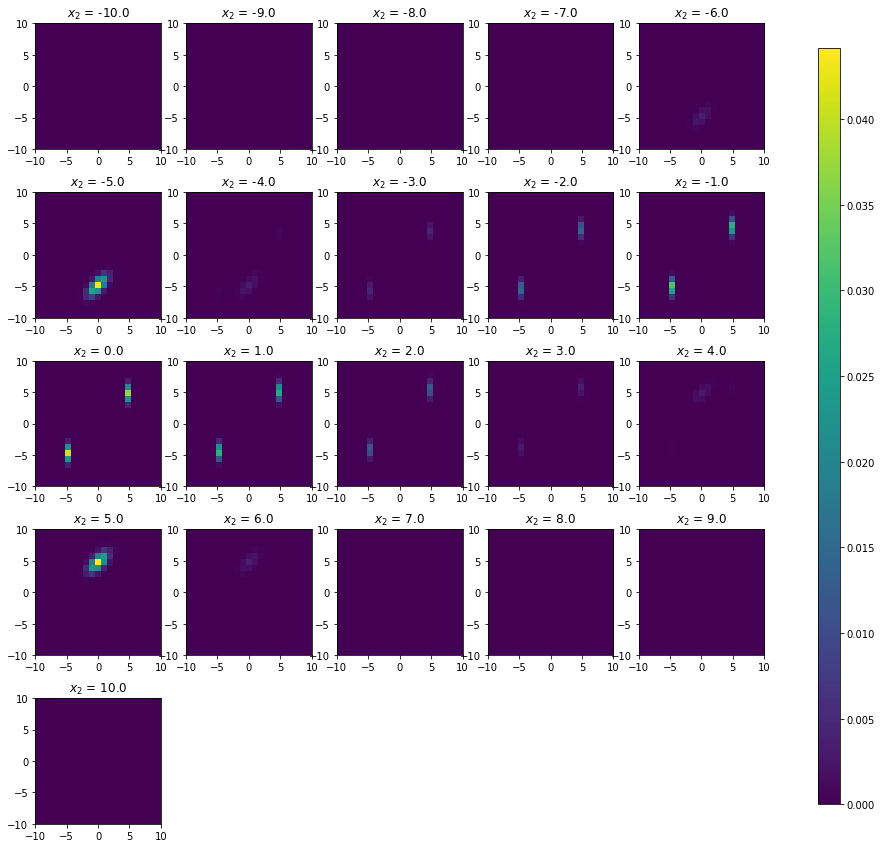

In [8]:
# Compute log likelihood at each point on a grid
n_grids = 21 # number of grid points
x_, y_, z_ = np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids)
x_grid, y_grid, z_grid = np.meshgrid(x_, y_, z_)
grids = np.column_stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
ll, _ = model(grids.astype('float32'), sampling=False)
ll = np.reshape(ll, (n_grids, n_grids, n_grids))
        
# Show the fit loglikelihood (slices of z-axis)
n_subplot_rows = 5
fig, ax = plt.subplots(n_subplot_rows, n_grids // n_subplot_rows + 1, figsize=(15, 15))
for i in range(n_subplot_rows):
    for j in range(n_grids // n_subplot_rows + 1):
        idx = i * (n_grids // n_subplot_rows + 1) + j
        if idx < n_grids:
            im = ax[i, j].imshow(np.exp(ll)[:, :, idx], extent=(-10, 10, -10, 10), origin='lower',
                                 vmin=0, vmax=np.exp(ll).max())
            ax[i, j].title.set_text('$x_2$ = {}'.format(z_[idx]))
        else:
            ax[i, j].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Output trainable variables

In [9]:
{v.name: v.numpy() for v in model.trainable_variables}

{'nu:0': array([16.696337, 17.003902, 16.118868, 17.060108], dtype=float32),
 'W_tril:0': array([[[ 0.79711527,  0.        ,  0.        ],
         [-0.00213974,  0.26741   ,  0.        ],
         [ 0.00662654, -0.07768105,  0.17881869]],
 
        [[ 0.30642357,  0.        ,  0.        ],
         [-0.17801458,  0.23510614,  0.        ],
         [-0.00596078, -0.00421279,  0.5484302 ]],
 
        [[ 0.33124697,  0.        ,  0.        ],
         [-0.19885679,  0.23220624,  0.        ],
         [-0.01168822,  0.00350982,  0.5515621 ]],
 
        [[ 0.7637535 ,  0.        ,  0.        ],
         [-0.00157213,  0.25438264,  0.        ],
         [ 0.00369484, -0.07951436,  0.17114939]]], dtype=float32),
 'mu0:0': array([[-4.991586  , -5.044743  , -0.11443501],
        [ 0.04611373,  5.0003004 ,  5.015073  ],
        [-0.03693366, -5.068515  , -5.005246  ],
        [ 4.993371  ,  4.952152  , -0.04238801]], dtype=float32),
 'lambda:0': array([10.579566, 10.529141, 10.499712, 10.568788

## Pairwise plot

Mean of covariance matrices (for each component):
[array([[ 0.1240587 , -0.00376949, -0.01808484],
       [-0.00376949,  1.3062912 ,  0.7228395 ],
       [-0.01808485,  0.7228395 ,  2.4682791 ]], dtype=float32), array([[1.2881188 , 0.81498045, 0.00486619],
       [0.8149805 , 1.4057713 , 0.0033113 ],
       [0.00486619, 0.0033113 , 0.25509527]], dtype=float32), array([[ 1.3060204 ,  0.9211218 ,  0.00601575],
       [ 0.9211218 ,  1.53991   , -0.00413906],
       [ 0.00601575, -0.00413906,  0.26934597]], dtype=float32), array([[ 1.3125962e-01,  2.6494442e-04, -8.1731463e-03],
       [ 2.6494454e-04,  1.4430683e+00,  8.2021505e-01],
       [-8.1731472e-03,  8.2021505e-01,  2.5948520e+00]], dtype=float32)]
Mean of mus (for each component):
[array([-4.9910693 , -5.0517745 , -0.11379255], dtype=float32), array([0.04472555, 5.0017214 , 5.013861  ], dtype=float32), array([-0.03448078, -5.0708127 , -5.0043263 ], dtype=float32), array([ 4.9942584,  4.956559 , -0.0435407], dtype=float32)]


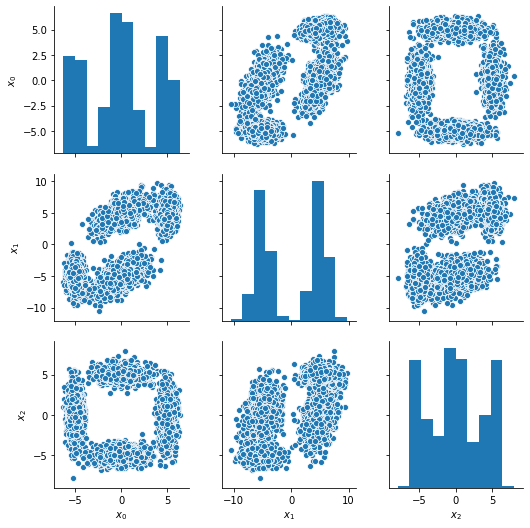

In [10]:
test_size = 10000

# sample covariance matrix
invcov = tfd.Wishart(df=model.nu,
                     scale_tril=model.W_tril,
                     validate_args=True, allow_nan_stats=False)
invcov_sample = invcov.sample(test_size)
invcov_sample += (eps * tf.matrix_diag(tf.ones((test_size, n_components, n_dims))))
cov_sample = tf.matrix_inverse(invcov_sample)
print('Mean of covariance matrices (for each component):\n{}'.format(
    [tf.reduce_mean(cov_sample[:, i], axis=0).numpy() for i in range(model.n_components)]))

# sample mean
mu_cov = tf.matrix_inverse(
    tf.stack(list(map(mul, tf.unstack(model.lmbd), [tf.eye(n_dims)] * n_components))) * invcov.sample(1)[0])
mu = tfd.MultivariateNormalTriL(loc=model.mu0,
                                scale_tril=tf.cholesky(mu_cov),
                                validate_args=True, allow_nan_stats=False)
mu_sample = mu.sample(test_size)
print('Mean of mus (for each component):\n{}'.format(
    [tf.reduce_mean(mu_sample[:, i], axis=0).numpy() for i in range(model.n_components)]))

# sample theta
theta = tfd.Dirichlet(concentration=model.counts,
                      validate_args=True, allow_nan_stats=False)
theta_sample = theta.sample(test_size)

# build Gaussian mixture model and sample
gmm = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                  components=[tfd.MultivariateNormalTriL(loc=mu_sample[:, i],
                                                         scale_tril=tf.cholesky(cov_sample[:, i]))
                              for i in range(model.n_components)])
gmm_sample = gmm.sample(1)[0]

# build dataset
dataset = pd.DataFrame({'$x_0$': gmm_sample[:, 0],
                        '$x_1$': gmm_sample[:, 1],
                        '$x_2$': gmm_sample[:, 2]})
fig_sns = sns.pairplot(dataset)